# Building's detection 
Project made by Egor Shestopalov

Email: shestopalovegor@gmail.com

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import *
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [57]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
!ls drive/Buildings_detection/data

## Preparing data

The data was made with the help of script data_maker.py. Certain bad images (just black squares) were not included into data. 

The data is 4D tensors: (276, 560, 560, 3) for X and (276, 560, 5600, 1) for y. It was already normilized in the script data_maker.py. 



In [0]:
x_path = 'drive/Buildings_detection/data/0.05threshold/x_train.npy'
y_path = 'drive/Buildings_detection/data/0.05threshold/y_train.npy'
x_val_path = 'drive/Buildings_detection/data/0.05threshold/x_val.npy'
y_val_path = 'drive/Buildings_detection/data/0.05threshold/y_val.npy'

# x_train_raw = np.load(x_path)
# print('Loaded x_train_raw')
# y_train_raw = np.load(y_path)
# print('Loaded y_train_raw')
# x_val_raw = np.load(x_val_path)
# print('Loaded x_val_raw')
# y_val_raw = np.load(y_val_path)
# print('Loaded y_val_raw')
x_train = np.load(x_path)
y_train = np.load(y_path)
x_val = np.load(x_val_path)
y_val = np.load(y_val_path)

This problem of detection of all pixels which belong to buildings is a segmentation problem. A good arcitechture of neural network for it is U-net.

The essential moment of U-net is that you need to always divide by the same number (often 2) to be able to segment without losing any pixels. So I had an option to use windows of shapes (256, 256), (512, 512) (less are too small).
For this task windows of the shape (512, 512) seem too big. The original size of samples is 650. It means that it is possible to get only one whole picture from example. Others will have little new data.

So I will choose the window (256, 256).

**Cropping**

Each example can be cropped into 4 full parts and 5 partly. 

The neural network will learn ignore black areas itself.

In [0]:
def crop_windows(x_data, y_data, window_size: tuple, n_channels: int, threshold: float):
    """
    Crops from (650*650) image 9 (256,256) images. 
    Threshold regulates how much images with no buildings will be in x_data (and y_data)
    """
  
    HEIGHT, WIDTH = window_size[0], window_size[1]

    x_list = []
    y_list = []

    for i in range(x_data.shape[0]):
        img = x_data[i, :, :, :]
        mask = y_data[i, :, :, :]

        for row in range(3):
            for col in range(3):
                temp_img = np.zeros(shape=(HEIGHT, WIDTH, n_channels))
                temp_mask = np.zeros(shape=(HEIGHT, WIDTH, 1))
                y0, y1 = row * HEIGHT, (row+1) * HEIGHT
                x0, x1 = col * WIDTH, (col+1) * WIDTH
                (avlbl_y, avlbl_x, _) = img[y0:y1, x0:x1, :].shape
                temp_mask[:avlbl_y, :avlbl_x, :] = mask[y0:y1, x0:x1, :]

                if len(temp_mask[temp_mask == 1]) / len(temp_mask[temp_mask == 0]) < threshold:
                    continue

                temp_img[:avlbl_y, :avlbl_x, :] = img[y0:y1, x0:x1, :]
                x_list.append(np.copy(temp_img))
                y_list.append(np.copy(temp_mask))

    length = len(x_list)
    x_data_proc = np.empty(shape=(length, HEIGHT, WIDTH, n_channels))
    y_data_proc = np.empty(shape=(length, HEIGHT, WIDTH, 1))

    for i in range(length):
        x_data_proc[i, :, :, :] = x_list[i]
        y_data_proc[i, :, :, :] = y_list[i]

    return x_data_proc, y_data_proc

In [0]:
x_train, y_train = crop_windows(x_train_raw, y_train_raw, (256, 256), 3)
del x_train_raw, y_train_raw
x_val, y_val = crop_windows(x_val_raw, y_val_raw, (256,256), 3)
del x_val_raw, y_val_raw

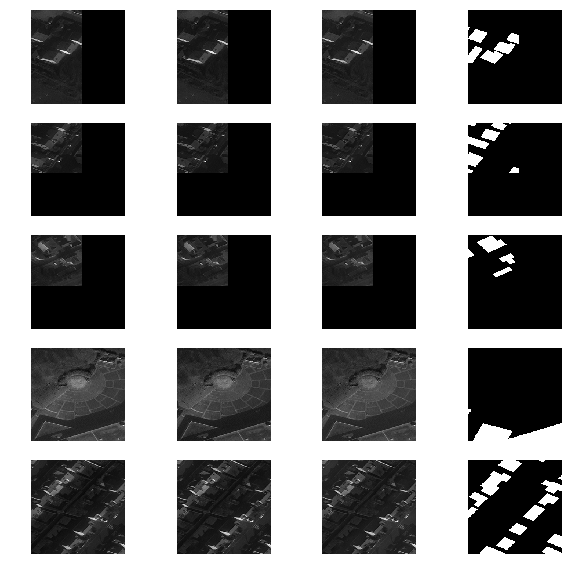

In [10]:
fig, ax = plt.subplots(5, 4, figsize=(10,10))
for i in range(5):
  j = i + 50
  ax[i][0].imshow(x_train[j, :, :, 0], cmap='gray')
  ax[i][0].axis('off')
  ax[i][1].imshow(x_train[j, :, :, 1], cmap='gray') 
  ax[i][1].axis('off')
  ax[i][2].imshow(x_train[j, :, :, 2], cmap='gray')
  ax[i][2].axis('off')
  ax[i][3].imshow(y_train[j, :, :, 0], cmap='gray')
  ax[i][3].axis('off')

In [56]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
x_val = x_val[:95, :, :, :]
y_val = y_val[:95, :, :, :]

(548, 256, 256, 3) (548, 256, 256, 1)
(138, 256, 256, 3) (138, 256, 256, 1)


## Arcitechture and learning

In segmentation problem dice coefficient is used. It shows how much two samples are similar.

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [0]:
def my_generator(X_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=0.1).flow(X_train, X_train, batch_size, seed=42)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=42)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

In [0]:
HEIGHT, WIDTH, N_CHANNELS = 256, 256, 3

### First architecture 

In [0]:
input_layer = Input(shape=(HEIGHT, WIDTH, N_CHANNELS))

c1 = Conv2D(8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)

c2 = Conv2D(16, kernel_size=(3,3), activation='relu', padding='same')(l)
c2 = Conv2D(16, kernel_size=(3,3), activation='relu', padding='same')(c2)
l = MaxPool2D(strides=(2,2))(c2)

c3 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(l)
c3 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(c3)
l = MaxPool2D(strides=(2,2))(c3)

c4 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(l)
c4 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(c4)
l = MaxPool2D(strides=(2,2))(c4) 

c5 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(l)
c5 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(c5)
l = MaxPool2D(strides=(2,2))(c5)

c6 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same')(l)
dropout = Dropout(0.3)(c6)
c6 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same')(dropout)

up6 = Conv2DTranspose(128, (3,3), strides=(2, 2), activation='relu', padding='same')(c6)
up6 = concatenate([up6, c5])
up6 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(up6)

up7 = Conv2DTranspose(64, (3,3), strides=(2, 2), activation='relu', padding='same')(up6)
up7 = concatenate([up7, c4])
up7 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(up7)

up8 = Conv2DTranspose(32, (3,3), strides=(2, 2), activation='relu', padding='same')(up7)
up8 = concatenate([up8, c3])
up8 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(up8)

up9 = Conv2DTranspose(16, (3,3), strides=(2, 2), activation='relu', padding='same')(up8)
up9 = concatenate([up9, c2])
up9 = Conv2D(16, kernel_size=(3,3), activation='relu', padding='same')(up9)

up10 = Conv2DTranspose(8, (3,3), strides=(2, 2), activation='relu', padding='same')(up9)
up10 = concatenate([up10, c1])
up10 = Conv2D(8, kernel_size=(3,3), activation='relu', padding='same')(up10)

c11 = Conv2D(4, (3,3), activation='relu', padding='same')(up10)

c12 = Conv2D(1, (1,1), activation='sigmoid', padding='same')(c11)

model = Model(input_layer, c12)

In [0]:
model.compile(optimizer=Adam(1e-3),
           loss='binary_crossentropy',
           metrics=[dice_coef])

In [0]:
weight_name = 'second_b_experiment.h5'

weight_saver = ModelCheckpoint(weight_name, monitor='val_dice_coef', 
                                save_best_only=True, save_weights_only=True)
# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)
reducer = ReduceLROnPlateau(monitor='val_loss', factor = 0.5, patience = 5)

In [57]:
history = model.fit_generator(my_generator(x_train, y_train, 16),
                              steps_per_epoch=18,
                             epochs=30,
                             validation_data=(x_val, y_val),
                             verbose=2,
                             callbacks=[weight_saver, reducer])

Epoch 1/30
 - 95s - loss: 0.4216 - dice_coef: 0.1607 - val_loss: 0.3363 - val_dice_coef: 0.1901
Epoch 2/30
 - 87s - loss: 0.3434 - dice_coef: 0.2564 - val_loss: 0.3195 - val_dice_coef: 0.2809
Epoch 3/30
 - 90s - loss: 0.3294 - dice_coef: 0.2869 - val_loss: 0.3027 - val_dice_coef: 0.2996
Epoch 4/30
 - 87s - loss: 0.3259 - dice_coef: 0.2971 - val_loss: 0.2924 - val_dice_coef: 0.2959
Epoch 5/30
 - 90s - loss: 0.3172 - dice_coef: 0.3006 - val_loss: 0.3012 - val_dice_coef: 0.3043
Epoch 6/30
 - 87s - loss: 0.3268 - dice_coef: 0.3031 - val_loss: 0.3195 - val_dice_coef: 0.2938
Epoch 7/30
 - 92s - loss: 0.3193 - dice_coef: 0.3098 - val_loss: 0.2881 - val_dice_coef: 0.3035
Epoch 8/30
 - 88s - loss: 0.3184 - dice_coef: 0.3022 - val_loss: 0.2877 - val_dice_coef: 0.2955
Epoch 9/30
 - 91s - loss: 0.3170 - dice_coef: 0.3135 - val_loss: 0.2839 - val_dice_coef: 0.2985
Epoch 10/30
 - 88s - loss: 0.3050 - dice_coef: 0.3270 - val_loss: 0.2851 - val_dice_coef: 0.3119
Epoch 11/30
 - 92s - loss: 0.3043 - dic

In [0]:
!mv 'second_b_experiment.h5' 'drive/Buildings_detection/weights'

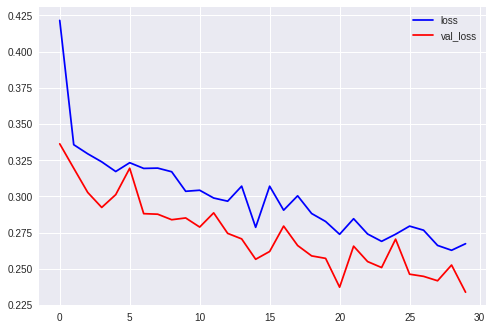

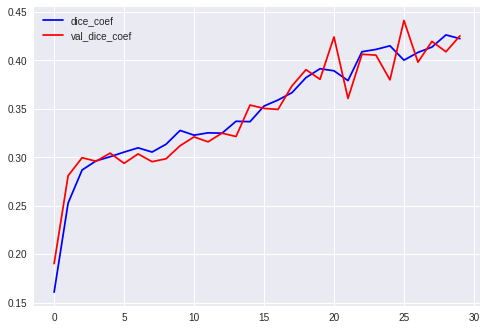

In [59]:
plt.plot(history.history['loss'], color='b', label='loss')
plt.plot(history.history['val_loss'], color='r', label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['dice_coef'], color='b', label='dice_coef')
plt.plot(history.history['val_dice_coef'], color='r', label='val_dice_coef')
plt.legend()
plt.show()

In [34]:
!ls drive/Buildings_detection/data/

x_test.npy  x_train.npy  x_val.npy  y_test.npy	y_train.npy  y_val.npy


In [0]:
x_test_path = 'drive/Buildings_detection/data/x_testt.npy'
y_test_path = 'drive/Buildings_detection/data/y_test.npy'

x_test = np.load(x_test_path)
print('Loaded x_test_raw')
y_test = np.load(y_test_path)
print('Loaded y_test_raw')

In [0]:
x_test, y_test = crop_windows(x_test_raw, y_test_raw, (256, 256), 3)
del x_test_raw, y_test_raw

In [0]:
weight_path = 'drive/Buildings_detection/weights/'
model.load_weights(weight_path + 'second_b_experiment.h5')

The model was **underfitted**. It last sigmoid leyer even cuold not classify on two classes becouse all the weights were under 0.5 probability.

In [0]:
origin_pred = model.predict(x_test)

pred = np.copy(origin_pred)
pred[pred > 0.2] = 1
pred[pred <= 0.2] = 0

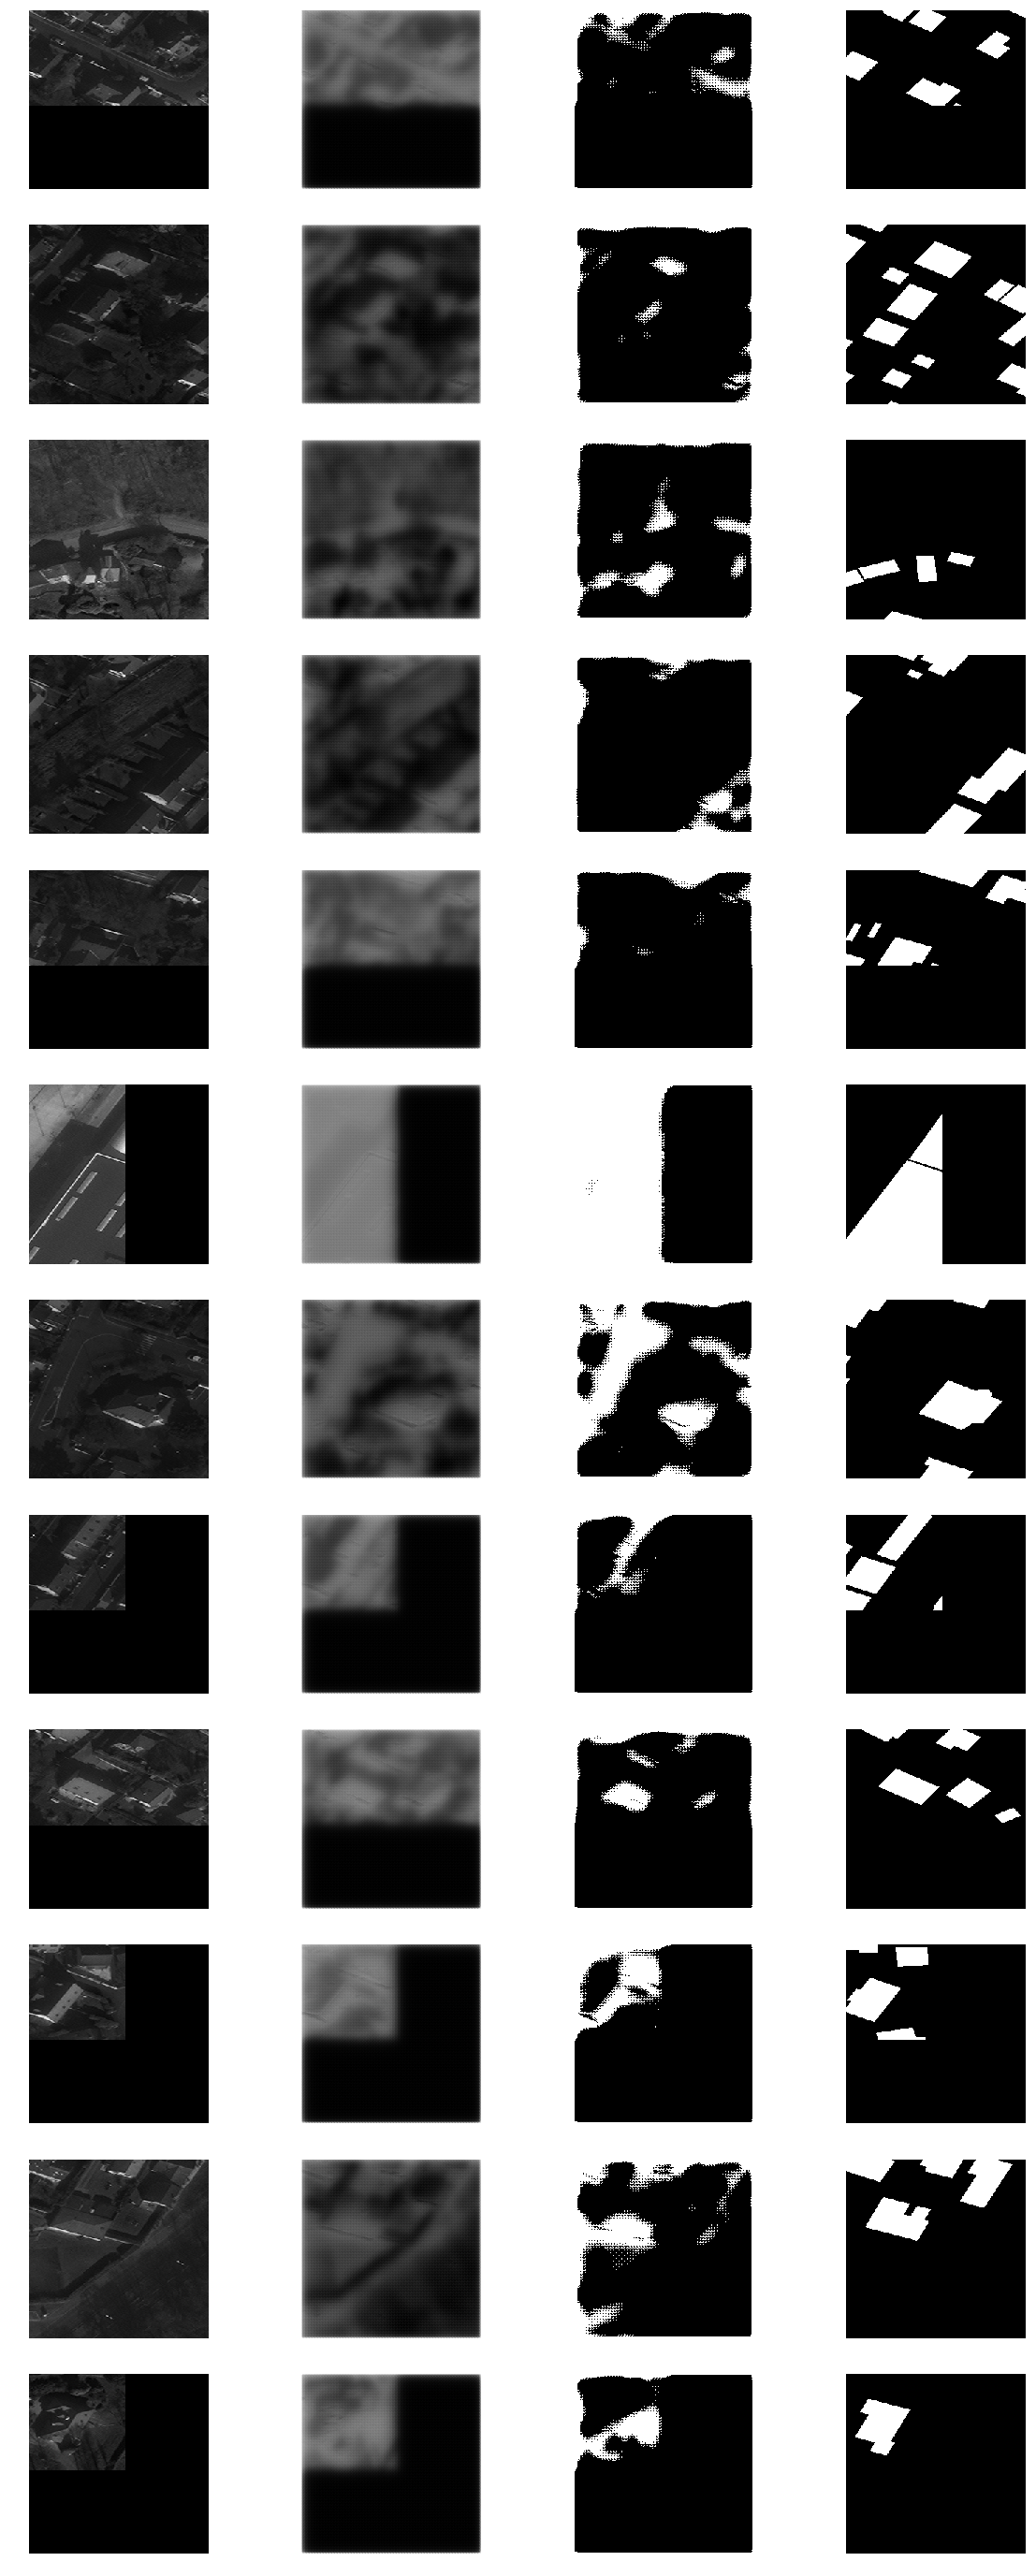

In [76]:
fig, ax = plt.subplots(12,4, figsize=(20,50))
for i in range(12):
  j = i + 20
  ax[i][0].imshow(x_test[j,:,:,0], cmap='gray')
  ax[i][0].axis('off')
  ax[i][1].imshow(origin_pred[j,:,:,0], cmap='gray')
  ax[i][1].axis('off')
  ax[i][2].imshow(pred[j,:,:,0], cmap='gray')
  ax[i][2].axis('off')
  ax[i][3].imshow(y_test[j,:,:,0], cmap='gray')
  ax[i][3].axis('off')


### Second architecture

**A experiment**

This architechture is a U-net version of ZFTurbo (https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model)

In [0]:
HEIGHT, WIDTH, N_CHANNELS = 256, 256, 3

In [0]:
def double_conv_layer(x, filters, batch_norm=True):
  conv = Conv2D(filters, (3, 3), padding='same')(x)
  if batch_norm:
    conv = BatchNormalization(axis=3)(conv)
  conv = Activation('relu')(conv)
  conv = Conv2D(filters, (3, 3), padding='same')(conv)
  if batch_norm:
    conv = BatchNormalization(axis=3)(conv)
  conv = Activation('relu')(conv)
  return conv

In [0]:
filters = 8

input = Input((HEIGHT, WIDTH, N_CHANNELS))

conv256 = double_conv_layer(input, 2*filters)
pool128 = MaxPooling2D((2, 2))(conv256)

conv128 = double_conv_layer(pool128, 4*filters)
pool64 = MaxPool2D((2, 2))(conv128)

conv64 = double_conv_layer(pool64, 8*filters)
pool32 = MaxPool2D((2, 2))(conv64)

conv32 = double_conv_layer(pool32, 16*filters)
pool16 = MaxPool2D((2, 2))(conv32)

conv16 = double_conv_layer(pool16, 32*filters)
pool8 = MaxPool2D((2, 2))(conv16)

conv8 = double_conv_layer(pool8, 64*filters)

up16 = concatenate([UpSampling2D((2, 2))(conv8), conv16], axis=3)
up_conv_16 = double_conv_layer(up16, 32*filters)

up32 = concatenate([UpSampling2D((2, 2))(up_conv_16), conv32], axis=3)
up_conv_32 = double_conv_layer(up32, 16*filters)

up64 = concatenate([UpSampling2D((2, 2))(up_conv_32), conv64], axis=3)
up_conv_64 = double_conv_layer(up64, 8*filters)

up128 = concatenate([UpSampling2D((2, 2))(up_conv_64), conv128], axis=3)
up_conv_128 = double_conv_layer(up128, 4*filters)

up256 = concatenate([UpSampling2D((2, 2))(up_conv_128), conv256], axis=3)
up_conv_256 = double_conv_layer(up256, 2*filters)

conv_final = Conv2D(1, (1,1), padding='same')(up_conv_256)
conv_final = Activation('sigmoid')(conv_final)

model = Model(input, conv_final)

In [0]:
model.summary()

The dice coeff used in this realization of U-net actually is not a Dice coeff.

True dice_coeff $$\frac{2|X \cap Y|}{|X| + |Y|} $$

Custom dice_coeff $$ \frac{|X \cap Y|}{|X| + |Y| - |X \cap Y|} $$

After thinking about two of them for me it seems that the second better penetalize. The second also less then the origin coefficient with the same data for equasion.


In [0]:
def dice_coeff(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def dice_coeff_loss(y_true, y_pred):
  return -dice_coeff(y_true, y_pred)

In [0]:
weights_name = 'third_a_experiment.h5'
epochs = 200
patience = 20
batch_size = 16
learning_rate = 0.001

optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=dice_coeff_loss, metrics=[dice_coeff])

callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, min_delta=0.00001, verbose=1, mode='min'),
            EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
            ModelCheckpoint('temp' + weights_name, monitor='val_loss', save_best_only=True, verbose=0)]

In [30]:
history = model.fit_generator(my_generator(x_train, y_train, 16),
                             epochs=epochs,
                             steps_per_epoch=200,
                             validation_data=(x_val, y_val),
                             validation_steps=200,
                             verbose=2,
                             callbacks=callbacks)

model.save_weights(weights_name)


Epoch 1/200
 - 115s - loss: -3.2220e-01 - dice_coeff: 0.3222 - val_loss: -1.5818e-01 - val_dice_coeff: 0.1582
Epoch 2/200
 - 100s - loss: -4.2736e-01 - dice_coeff: 0.4274 - val_loss: -3.8353e-01 - val_dice_coeff: 0.3835
Epoch 3/200
 - 102s - loss: -4.7252e-01 - dice_coeff: 0.4725 - val_loss: -4.6130e-01 - val_dice_coeff: 0.4613
Epoch 4/200
 - 102s - loss: -5.2242e-01 - dice_coeff: 0.5224 - val_loss: -4.8465e-01 - val_dice_coeff: 0.4847
Epoch 5/200
 - 102s - loss: -5.4415e-01 - dice_coeff: 0.5441 - val_loss: -4.3823e-01 - val_dice_coeff: 0.4382
Epoch 6/200
 - 103s - loss: -5.5278e-01 - dice_coeff: 0.5528 - val_loss: -5.3276e-01 - val_dice_coeff: 0.5328
Epoch 7/200
 - 102s - loss: -5.6455e-01 - dice_coeff: 0.5645 - val_loss: -5.7324e-01 - val_dice_coeff: 0.5732
Epoch 8/200
 - 102s - loss: -5.8193e-01 - dice_coeff: 0.5819 - val_loss: -5.6140e-01 - val_dice_coeff: 0.5614
Epoch 9/200
 - 103s - loss: -5.8237e-01 - dice_coeff: 0.5824 - val_loss: -5.4363e-01 - val_dice_coeff: 0.5436
Epoch 10/2

The mistake of in this experiment was that train and validation data did not include examples with no buildings on them. It caused strong miastakes on forest and crop images.

In [0]:
x_test = np.load('drive/Buildings_detection/data/0.05threshold/x_test.npy')
y_test = np.load('drive/Buildings_detection/data/0.05threshold/y_test.npy')

In [0]:
x_test, y_test = crop_windows(x_test, y_test, (256, 256), 3, 0)

In [0]:
model.load_weights('drive/Buildings_detection/weights/third_a_experiment.h5')

On test the custom dice_coeff is:

In [39]:
perf = model.evaluate(x_test, y_test)
print('Custom Dice coefficient on test data: {:.2f}'.format(perf[1]))

504/504 [==============================] - 7s 14ms/step
Custom Dice coefficient on test data: 0.33


In [0]:
pred = model.predict(x_test)

origin_pred = np.copy(pred)

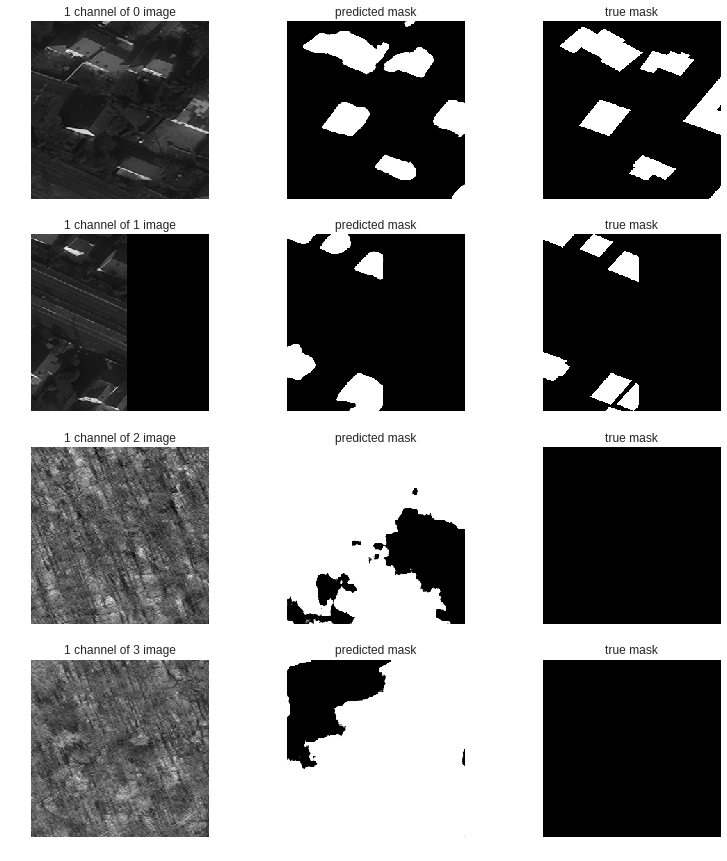

In [41]:
n = [10, 14, 18, 19]

fig, ax = plt.subplots(4,3, figsize=(13,15))
for i in range(4):
  j = n[i]
  ax[i][0].imshow(x_test[j,:,:,0], cmap='gray')
  ax[i][0].axis('off')
  ax[i][0].set_title('1 channel of {} image'.format(i))
  ax[i][1].imshow(pred[j,:,:,0], cmap='gray')
  ax[i][1].axis('off')
  ax[i][1].set_title('predicted mask')
  ax[i][2].imshow(y_test[j,:,:,0], cmap='gray')
  ax[i][2].axis('off')
  ax[i][2].set_title('true mask')

In [0]:
x_test_assembled = assemble_test(x_test)
y_test_assembled = assemble_test(y_test)
pred_assembled = assemble_test(pred)

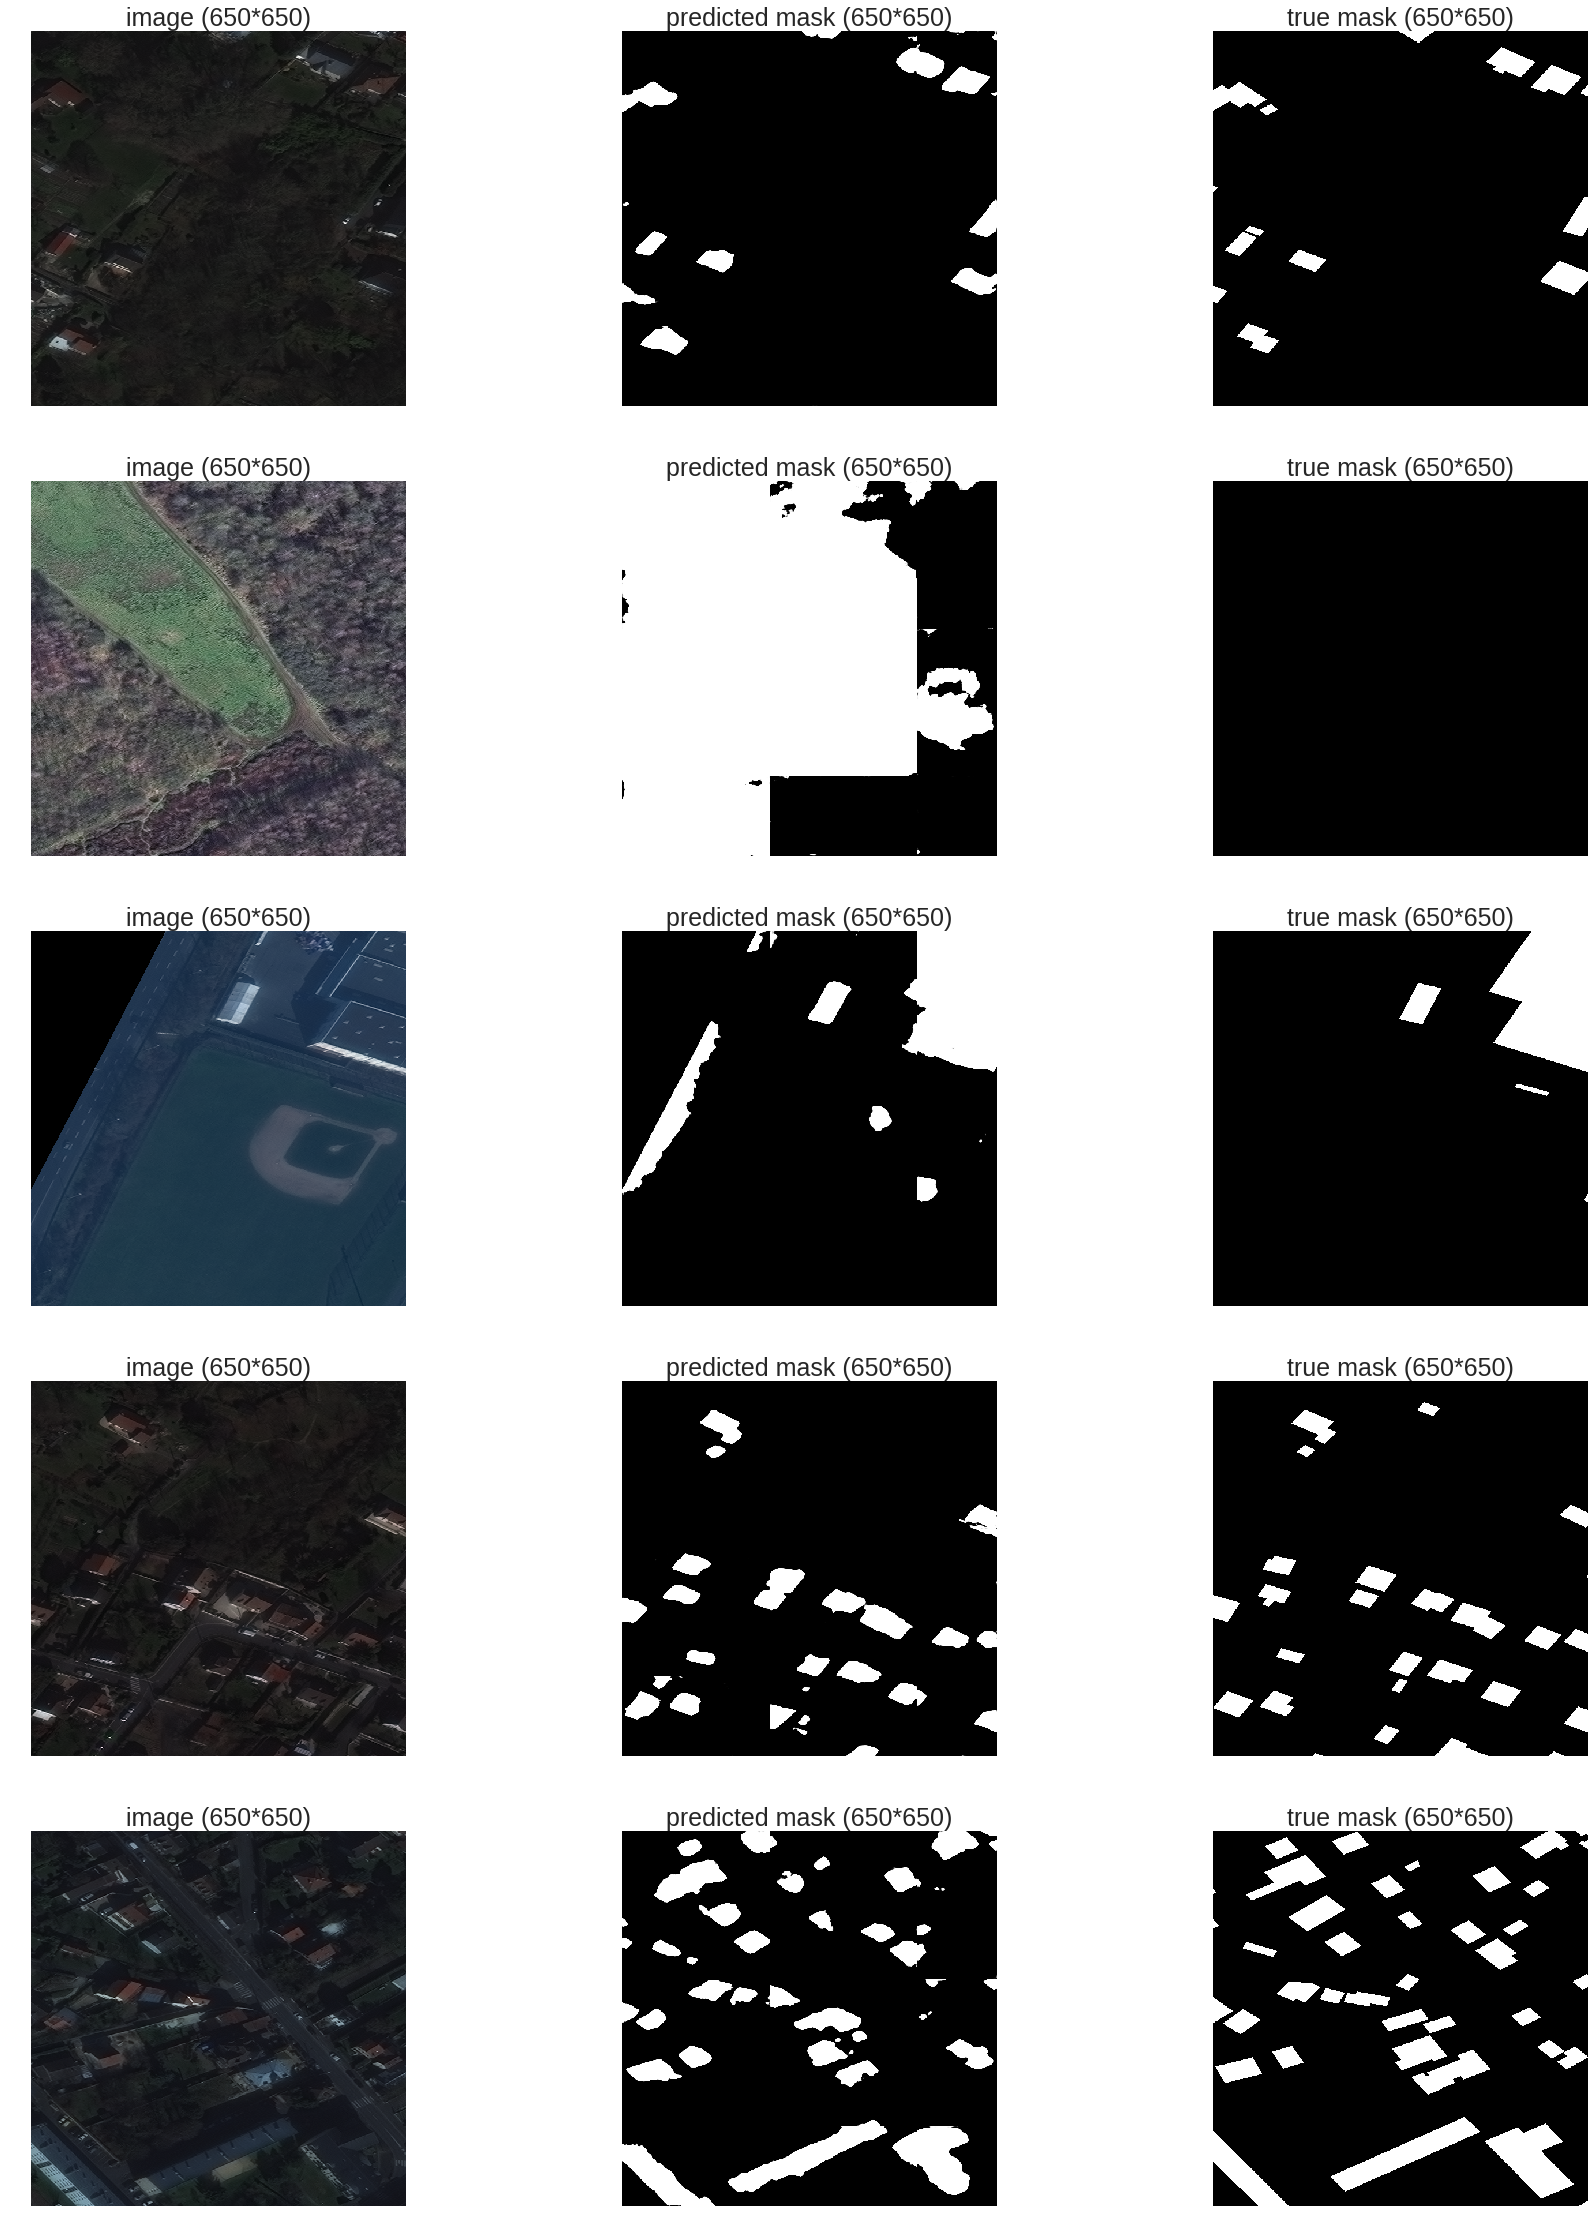

In [53]:
fig, ax = plt.subplots(5, 3, figsize=(30, 40))
for i in range(5):
  j = i + 6
  ax[i][0].imshow(x_test_assembled[j, :, :, :])
  ax[i][0].axis('off')
  ax[i][0].set_title('image (650*650)', size=25)
  ax[i][1].imshow(pred_assembled[j, :, :, 0], cmap='gray')
  ax[i][1].axis('off')
  ax[i][1].set_title('predicted mask (650*650)', size=25)
  ax[i][2].imshow(y_test_assembled[j, :, :, 0], cmap='gray')    
  ax[i][2].axis('off')
  ax[i][2].set_title('true mask (650*650)', size=25)

**B experiment**

For this experiment train and validation data had about 0.15 % of examples with no buildings at them.

In [0]:
x_path = 'drive/Buildings_detection/data/0.05thresh_0.15empty_images/x_train.npy'
y_path = 'drive/Buildings_detection/data/0.05thresh_0.15empty_images/y_train.npy'
x_val_path = 'drive/Buildings_detection/data/0.05thresh_0.15empty_images/x_val.npy'
y_val_path = 'drive/Buildings_detection/data/0.05thresh_0.15empty_images/y_val.npy'

x_train = np.load(x_path)
y_train = np.load(y_path)
x_val = np.load(x_val_path)
y_val = np.load(y_val_path)

In the example below we see these 'empty' images.

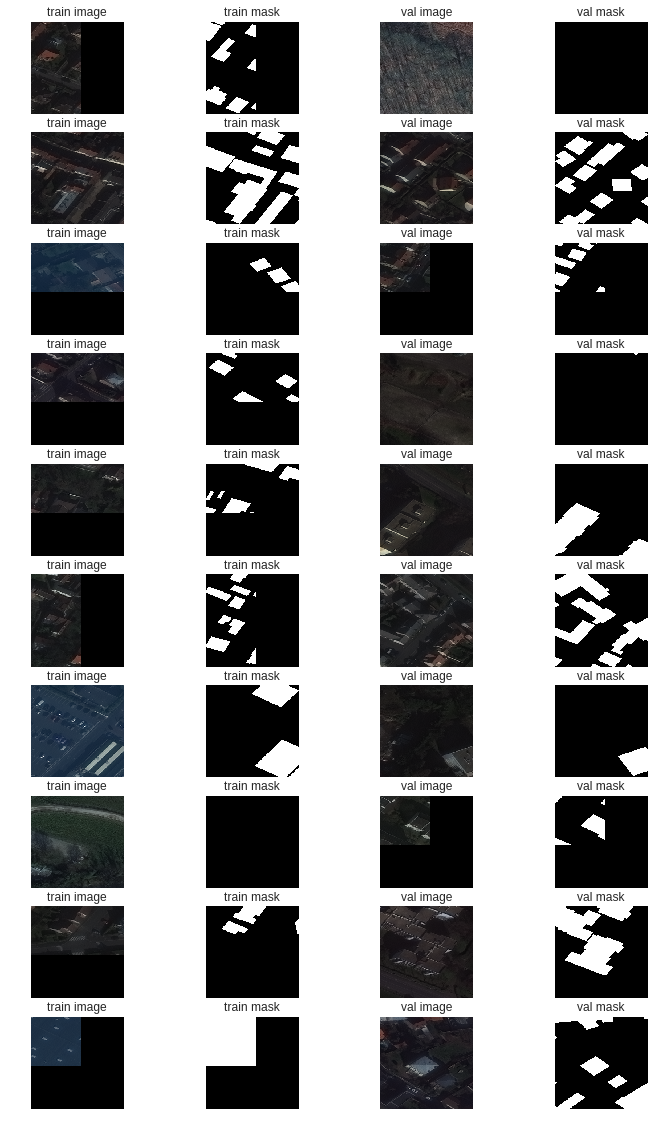

In [23]:
fig, ax = plt.subplots(10, 4, figsize=(12, 20))
for i in range(10):
  j = i
  ax[i][0].imshow(x_train[j, :, :, :])
  ax[i][0].axis('off')
  ax[i][0].set_title('train image')
  ax[i][1].imshow(y_train[j, :, :, 0], cmap='gray')
  ax[i][1].axis('off')
  ax[i][1].set_title('train mask')
  ax[i][2].imshow(x_val[j, :, :, :])    
  ax[i][2].axis('off')
  ax[i][2].set_title('val image')
  ax[i][3].imshow(y_val[j, :, :, 0], cmap='gray')    
  ax[i][3].axis('off')
  ax[i][3].set_title('val mask')

In [0]:
weights_name = 'third_b_experiment.h5'
epochs = 200
patience = 20
batch_size = 16
learning_rate = 0.001

optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=dice_coeff_loss, metrics=[dice_coeff])

callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, min_delta=0.00001, verbose=1, mode='min'),
            EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
            ModelCheckpoint('temp_' + weights_name, monitor='val_loss', save_best_only=True, verbose=0)]

In [27]:
history = model.fit_generator(my_generator(x_train, y_train, 16),
                             epochs=epochs,
                             steps_per_epoch=200,
                             validation_data=(x_val, y_val),
                             validation_steps=200,
                             verbose=2,
                             callbacks=callbacks)

model.save_weights(weights_name)

Epoch 1/200
 - 112s - loss: -2.9717e-01 - dice_coeff: 0.2972 - val_loss: -3.1304e-01 - val_dice_coeff: 0.3130
Epoch 2/200
 - 100s - loss: -4.4011e-01 - dice_coeff: 0.4401 - val_loss: -4.2697e-01 - val_dice_coeff: 0.4270
Epoch 3/200
 - 101s - loss: -4.9301e-01 - dice_coeff: 0.4930 - val_loss: -4.8114e-01 - val_dice_coeff: 0.4811
Epoch 4/200
 - 101s - loss: -5.2141e-01 - dice_coeff: 0.5214 - val_loss: -5.0073e-01 - val_dice_coeff: 0.5007
Epoch 5/200
 - 101s - loss: -5.4084e-01 - dice_coeff: 0.5408 - val_loss: -4.3572e-01 - val_dice_coeff: 0.4357
Epoch 6/200
 - 101s - loss: -5.5118e-01 - dice_coeff: 0.5512 - val_loss: -3.2965e-01 - val_dice_coeff: 0.3296
Epoch 7/200
 - 101s - loss: -5.6414e-01 - dice_coeff: 0.5641 - val_loss: -4.0162e-01 - val_dice_coeff: 0.4016
Epoch 8/200
 - 101s - loss: -5.7452e-01 - dice_coeff: 0.5745 - val_loss: -5.0877e-01 - val_dice_coeff: 0.5088
Epoch 9/200
 - 101s - loss: -5.7965e-01 - dice_coeff: 0.5796 - val_loss: -5.9230e-01 - val_dice_coeff: 0.5923
Epoch 10/2

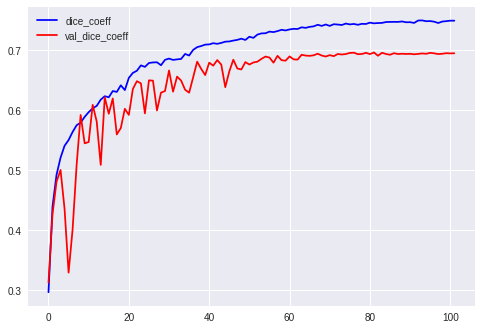

In [43]:
plt.plot(history.history['dice_coeff'], 'b', label='dice_coeff')
plt.plot(history.history['val_dice_coeff'], 'r', label='val_dice_coeff')
plt.legend()
plt.show()

In [0]:
model.load_weights('drive/Buildings_detection/weights/third_b_experiment.h5')

In [0]:
x_test_path = 'drive/Buildings_detection/data/0.05thresh_0.15empty_images/x_test.npy'
y_test_path = 'drive/Buildings_detection/data/0.05thresh_0.15empty_images/y_test.npy'

x_test = np.load(x_test_path)
y_test = np.load(y_test_path)

x_test, y_test = crop_windows(x_test, y_test, (256, 256), 3, 0)

On test the custom dice_coeff is:

In [29]:
perf = model.evaluate(x_test, y_test)
print('Custom Dice coefficient on test data: {:.2f}'.format(perf[1]))

504/504 [==============================] - 7s 13ms/step
Custom Dice coefficient on test data: 0.62


In [0]:
pred = model.predict(x_test)

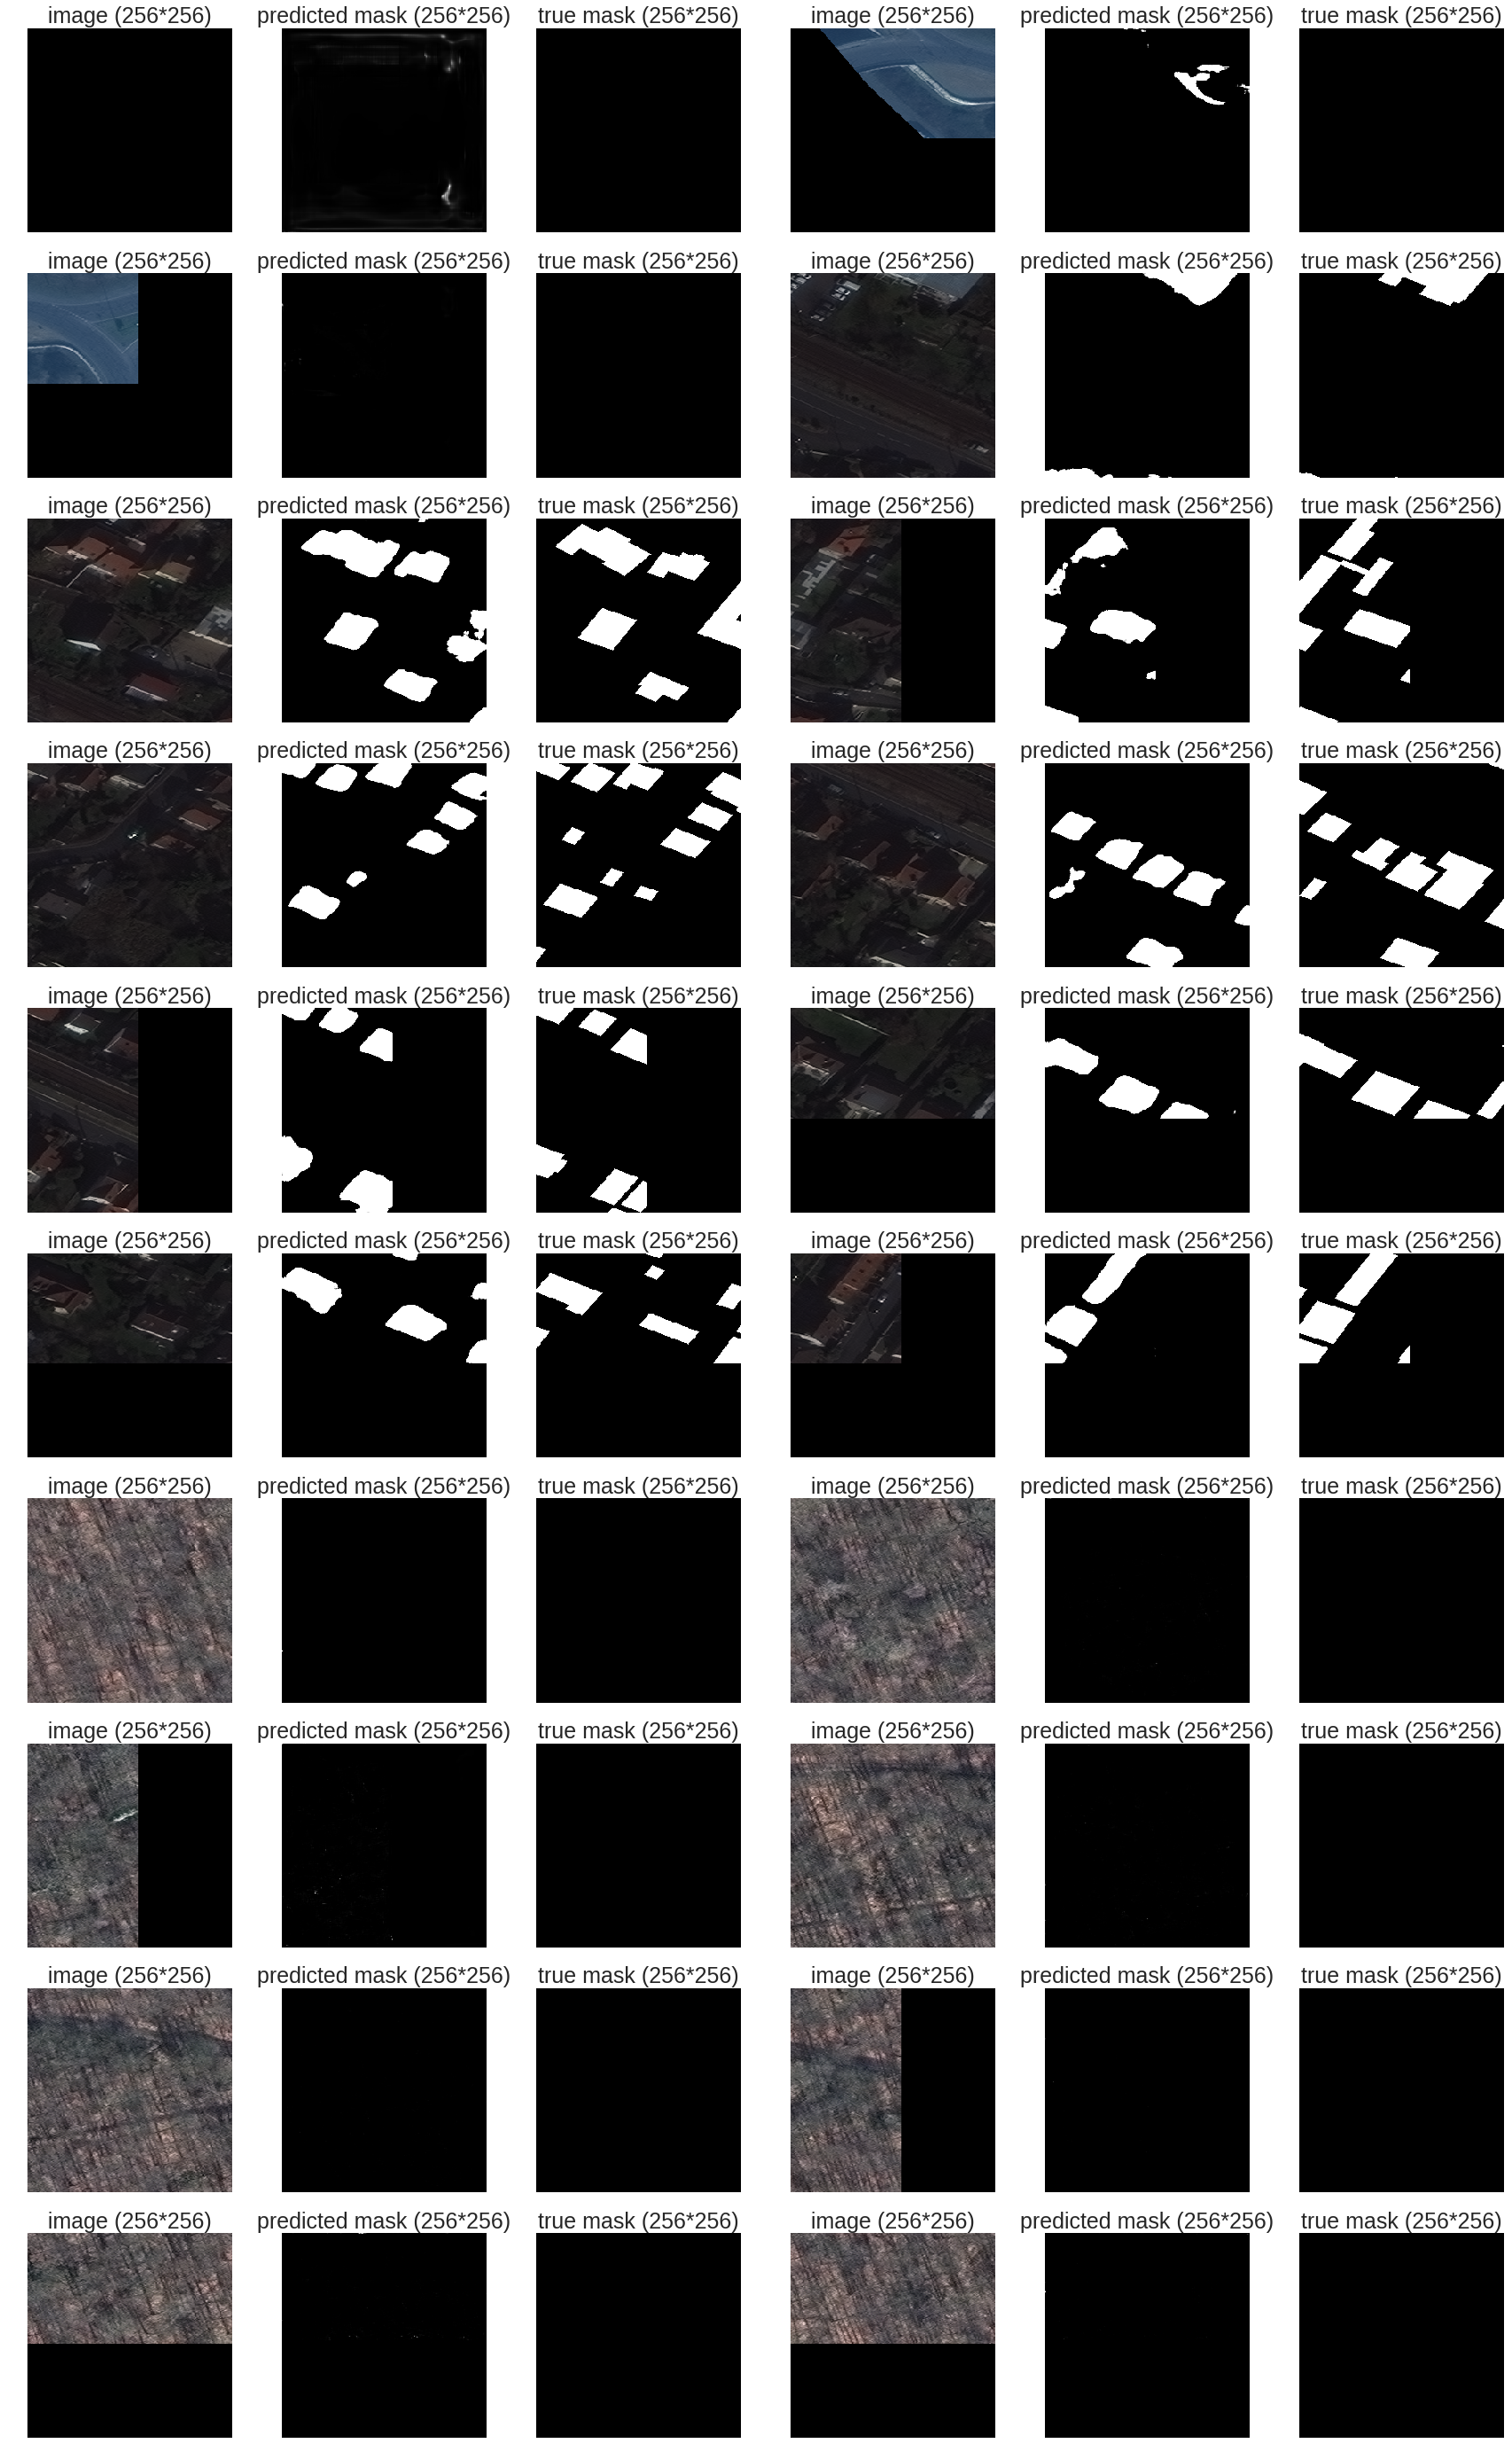

In [20]:
fig, ax = plt.subplots(10, 6, figsize=(30, 50))
for i in range(10):
  j = i + 3
  a = j * 2
  b = j * 2 + 1
  ax[i][0].imshow(x_test[a, :, :, :])
  ax[i][0].axis('off')
  ax[i][0].set_title('image (256*256)', size=25)
  ax[i][1].imshow(pred[a, :, :, 0], cmap='gray')
  ax[i][1].axis('off')
  ax[i][1].set_title('predicted mask (256*256)', size=25)
  ax[i][2].imshow(y_test[a, :, :, 0], cmap='gray')    
  ax[i][2].axis('off')
  ax[i][2].set_title('true mask (256*256)', size=25)
  ax[i][3].imshow(x_test[b, :, :, :])
  ax[i][3].axis('off')
  ax[i][3].set_title('image (256*256)', size=25)
  ax[i][4].imshow(pred[b, :, :, 0], cmap='gray')
  ax[i][4].axis('off')
  ax[i][4].set_title('predicted mask (256*256)', size=25)
  ax[i][5].imshow(y_test[b, :, :, 0], cmap='gray')    
  ax[i][5].axis('off')
  ax[i][5].set_title('true mask (256*256)', size=25)

In [0]:
def assemble_test(x):
  # assebple 650*650 image from windows 256*256
    new_lenght = x.shape[0]
    shape = x.shape[1:]

    ret = np.empty(shape=(new_lenght, 650, 650, shape[2]))

    for i in range(new_lenght // 9):
        img = np.zeros(shape=(3 * shape[0], 3 * shape[1], shape[2]))
        for row in range(3):
            for col in range(3):
                y0 = row * shape[0]
                y1 = (row + 1) * shape[0]
                x0 = col * shape[1]
                x1 = (col + 1) * shape[1]
                cur_n = 9*i + 3*row + col
                if shape[2] == 1:
                    img[y0:y1, x0:x1, 0] = x[cur_n, :, :, 0]
                else:
                    img[y0:y1, x0:x1, :] = x[cur_n, :, :, :]
        if shape[2] == 1:
            ret[i, :, :, 0] = img[:650, :650, 0]
        else:
            ret[i, :, :, :] = img[:650, :650, :]
    return ret

In [0]:
x_test_assembled = assemble_test(x_test)
y_test_assembled = assemble_test(y_test)
pred_assembled = assemble_test(pred)

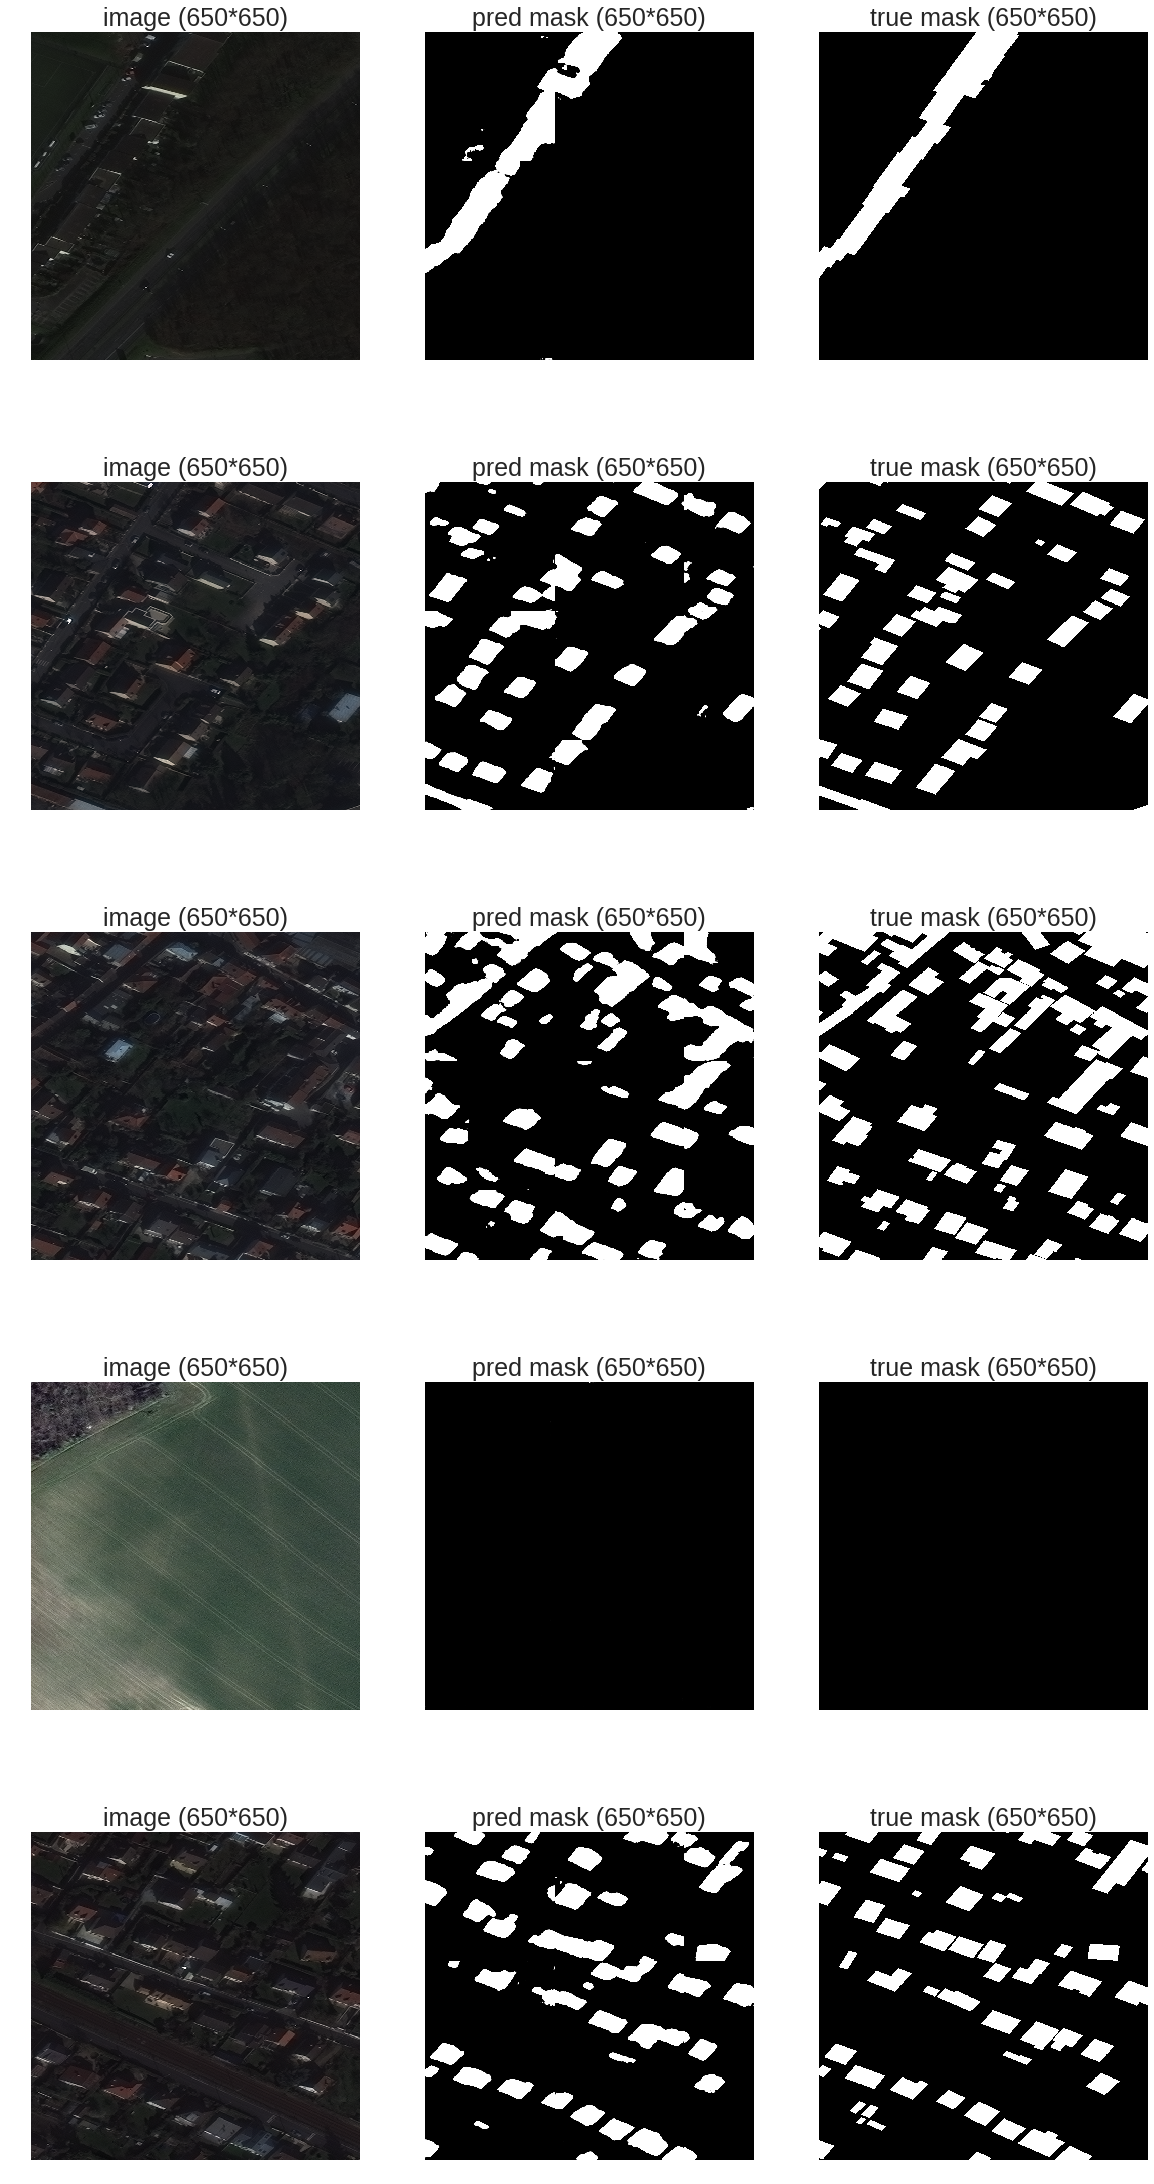

In [83]:
fig, ax = plt.subplots(5, 3, figsize=(20, 40))
a = 10
for i in range(5):
  t = i + a * 5
  ax[i][0].imshow(x_test_assembled[t, :, :, :])
  ax[i][0].axis('off')
  ax[i][0].set_title('image (650*650)', size=25)
  ax[i][1].imshow(pred_assembled[t, :, :, 0], cmap='gray')
  ax[i][1].axis('off')
  ax[i][1].set_title('pred mask (650*650)', size=25)
  ax[i][2].imshow(y_test_assembled[t, :, :, 0], cmap='gray')
  ax[i][2].axis('off')
  ax[i][2].set_title('true mask (650*650)', size=25)
# fig.savefig('drive/Buildings_detection/Results/result_{}'.format(a // 5 + 1), bbox_inches='tight', pad_inches=0.4)
